In [6]:
%pip install datasets

                                              0.0/515.2 kB ? eta -:--:--
     --                                      30.7/515.2 kB 1.3 MB/s eta 0:00:01
     -----                                 71.7/515.2 kB 653.6 kB/s eta 0:00:01
     ------                                92.2/515.2 kB 871.5 kB/s eta 0:00:01
     ----------------                       225.3/515.2 kB 1.3 MB/s eta 0:00:01
     ---------------------                  286.7/515.2 kB 1.2 MB/s eta 0:00:01
     ------------------------------------   491.5/515.2 kB 1.8 MB/s eta 0:00:01
     -------------------------------------- 515.2/515.2 kB 1.7 MB/s eta 0:00:00
                                              0.0/27.5 MB ? eta -:--:--
                                              0.5/27.5 MB 15.4 MB/s eta 0:00:02
     -                                        0.8/27.5 MB 8.8 MB/s eta 0:00:04
     --                                       1.6/27.5 MB 11.0 MB/s eta 0:00:03
     ----                                     3.0/27.5 M


[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
from huggingface_hub import login
from datasets import load_dataset
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import random
import base64
import io
from PIL import Image
import os
from tqdm import tqdm
from datasets import load_from_disk
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import layers, models, Input, optimizers, regularizers





# Class Weights calculated (Erythema)

In [ ]:

# 1. Load your cleaned CSV
csv_path = "SurgWound_Cleaned/train_data.csv"
df = pd.read_csv(csv_path)

# 2. Filter ONLY for Erythema rows
# We use the 'image_id' or 'question' to find them
erythema_df = df[df['image_id'].str.contains("erythema", case=False)]

# (Optional) Drop "Uncertain" if you decided to ignore it
erythema_df = erythema_df[erythema_df['answer'] != 'Uncertain'] 

# 3. Get the "y" (The text labels)
y_text = erythema_df['answer'].values

# 4. Convert Text Labels to Integers (0, 1, 2)
# We sort them so the order is always alphabetical:
# Existent -> 0, Non-existent -> 1, Uncertain -> 2
classes = np.unique(y_text)
label_map = {label: i for i, label in enumerate(classes)}
y_integers = np.array([label_map[label] for label in y_text])

print(f"✅ Found {len(y_integers)} Erythema samples.")
print(f"Mapping used: {label_map}")

# 5. Calculate the Weights
# This function automatically balances the classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)

# 6. Create the Dictionary for Keras
weights_dict = dict(enumerate(class_weights))

print("\nCopy and Paste this dictionary into your training code:")
print("="*50)
print(weights_dict)
print("="*50)

✅ Found 463 Erythema samples.
Mapping used: {'Existent': 0, 'Non-existent': 1}

Copy and Paste this dictionary into your training code:
{0: np.float64(1.7945736434108528), 1: np.float64(0.6931137724550899)}


# Class Weights calculated (Exudate_type)

In [ ]:

# 1. Load your cleaned CSV
csv_path = "SurgWound_Cleaned/train_data.csv"
df = pd.read_csv(csv_path)

# 2. Filter ONLY for exudate_type rows
# We use the 'image_id' or 'question' to find them
exudate_df = df[df['image_id'].str.contains("exudate_type", case=False)]

# 🛑 CRITICAL STEP: Filter for ONLY your 3 target classes
target_classes = ['Non-existent', 'Serous', 'Purulent']
exudate_df = exudate_df[exudate_df['answer'].isin(target_classes)]

# 3. Get the "y" (The text labels)
y_text = exudate_df['answer'].values

# 4. Convert Text Labels to Integers (0, 1, 2)
# We sort them so the order is always alphabetical:
# Existent -> 0, Non-existent -> 1, Uncertain -> 2
classes = np.unique(y_text)
label_map = {label: i for i, label in enumerate(classes)}
y_integers = np.array([label_map[label] for label in y_text])

print(f"✅ Found {len(y_integers)} valid samples.")
print(f"⚠️ Dropped {len(df) - len(y_integers)} rows (other fluid types).")
print(f"Mapping: {label_map}")

# 5. Calculate Weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)

# 6. Output
weights_dict = dict(enumerate(class_weights))

print("\n📋 Your New Weights Dictionary:")
print("="*50)
print(weights_dict)
print("="*50)

✅ Found 405 valid samples.
⚠️ Dropped 3030 rows (other fluid types).
Mapping: {'Non-existent': 0, 'Purulent': 1, 'Serous': 2}

📋 Your New Weights Dictionary:
{0: np.float64(0.3678474114441417), 1: np.float64(11.25), 2: np.float64(5.1923076923076925)}


# Erythema using pre-trained EfficientNetB0
(train: augmented, test: clean_validation, cross_validation: none)

Augmented Data

In [ ]:
# ==========================================
# 1. SETUP & PATHS
# ==========================================
TRAIN_DIR = "SurgWound_Augmented"        
TRAIN_CSV = "SurgWound_Augmented/train_aug_data.csv"
VAL_DIR = "SurgWound_Cleaned"            
VAL_CSV = "SurgWound_Cleaned/validation_data.csv"

# Your Calculated Weights for Erythema
CLASS_WEIGHTS = {
    0: 1.7945736434108528,  # Existent
    1: 0.6931137724550899   # Non-existent
}

IMG_SIZE = (224, 224)
BATCH_SIZE = 16  # Reduced batch size because EfficientNet is bigger
EPOCHS = 20      # More epochs, but we use EarlyStopping

# ==========================================
# 2. ADVANCED AUGMENTATION
# ==========================================
# EfficientNet expects raw pixel values (0-255), it handles normalization internally!
# We ADD brightness/contrast jitter to simulate different room lighting.
train_datagen = ImageDataGenerator(
    brightness_range=[0.8, 1.2], # Darker/Lighter
    channel_shift_range=20.0,    # Color shifts
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator() # No rescaling needed for EfficientNetB0

# ==========================================
# 3. DATA LOADERS
# ==========================================
train_df = pd.read_csv(TRAIN_CSV)
train_df['answer'] = train_df['answer'].astype(str)

val_df = pd.read_csv(VAL_CSV)
val_df = val_df[val_df['image_id'].str.contains("erythema", case=False)]
val_df['answer'] = val_df['answer'].astype(str)

train_gen = train_datagen.flow_from_dataframe(
    train_df, TRAIN_DIR, x_col="filename", y_col="answer",
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="sparse", shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df, VAL_DIR, x_col="filename", y_col="answer",
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="sparse", shuffle=False
)

# ==========================================
# 4. BUILD EFFICIENTNET MODEL
# ==========================================
def build_pro_model():
    inputs = Input(shape=(224, 224, 3))
    
    # Load EfficientNetB0 (Pre-trained)
    # Note: We unfreeze the top 20 layers IMMEDIATELY for better learning
    base_model = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=inputs)
    
    # Freeze most layers, train top 20
    base_model.trainable = True
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)  # Stabilizes training
    x = layers.Dense(256, activation='relu')(x) # Bigger Dense Layer
    x = layers.Dropout(0.4)(x)          # Higher Dropout to prevent overfitting
    
    outputs = layers.Dense(2, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name="Erythema_EfficientNet")
    
    # Use a slightly lower learning rate for safety
    model.compile(optimizer=optimizers.Adam(1e-4), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

model = build_pro_model()

# ==========================================
# 5. SMART TRAINING (CALLBACKS)
# ==========================================
# Reduce LR: If model gets stuck, slow down training
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=1e-6)

# Early Stop: If model stops improving, stop automatically
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

print("\n🚀 Starting Professional Training...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=CLASS_WEIGHTS,
    callbacks=[lr_reduction, early_stop],
    verbose=1
)

model.save("erythema_efficientnet_final.h5")
print("✅ Saved Pro Model: erythema_efficientnet_final.h5")

🚀 Starting Augmentation. Turning 463 images into 2778...


100%|██████████| 463/463 [04:32<00:00,  1.70it/s]


✅ Success! New dataset at: SurgWound_Augmented


In [7]:
# ==========================================
# 1. SETUP & PATHS
# ==========================================
TRAIN_DIR = "SurgWound_Augmented"        
TRAIN_CSV = "SurgWound_Augmented/train_aug_data.csv"
VAL_DIR = "SurgWound_Cleaned"            
VAL_CSV = "SurgWound_Cleaned/validation_data.csv"

# Your Calculated Weights for Erythema
CLASS_WEIGHTS = {0: 1.79, 1: 0.69}

IMG_SIZE = (224, 224)
BATCH_SIZE = 16  # Reduced batch size because EfficientNet is bigger
EPOCHS = 20      # More epochs, but we use EarlyStopping

# ==========================================
# 2. ADVANCED AUGMENTATION
# ==========================================
# EfficientNet expects raw pixel values (0-255), it handles normalization internally!
# We ADD brightness/contrast jitter to simulate different room lighting.
train_datagen = ImageDataGenerator(
    brightness_range=[0.8, 1.2], # Darker/Lighter
    channel_shift_range=20.0,    # Color shifts
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator() # No rescaling needed for EfficientNetB0

# ==========================================
# 3. DATA LOADERS
# ==========================================
train_df = pd.read_csv(TRAIN_CSV)
train_df['answer'] = train_df['answer'].astype(str)

val_df = pd.read_csv(VAL_CSV)
val_df = val_df[val_df['image_id'].str.contains("erythema", case=False)]
val_df['answer'] = val_df['answer'].astype(str)

train_gen = train_datagen.flow_from_dataframe(
    train_df, TRAIN_DIR, x_col="filename", y_col="answer",
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="sparse", shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df, VAL_DIR, x_col="filename", y_col="answer",
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="sparse", shuffle=False
)

# ==========================================
# 4. BUILD EFFICIENTNET MODEL
# ==========================================
def build_pro_model():
    inputs = Input(shape=(224, 224, 3))
    
    # Load EfficientNetB0 (Pre-trained)
    # Note: We unfreeze the top 20 layers IMMEDIATELY for better learning
    base_model = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=inputs)
    
    # Freeze most layers, train top 20
    base_model.trainable = True
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)  # Stabilizes training
    x = layers.Dense(256, activation='relu')(x) # Bigger Dense Layer
    x = layers.Dropout(0.4)(x)          # Higher Dropout to prevent overfitting
    
    outputs = layers.Dense(2, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name="Erythema_EfficientNet")
    
    # Use a slightly lower learning rate for safety
    model.compile(optimizer=optimizers.Adam(1e-4), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

model = build_pro_model()

# ==========================================
# 5. SMART TRAINING (CALLBACKS)
# ==========================================
# Reduce LR: If model gets stuck, slow down training
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=1e-6)

# Early Stop: If model stops improving, stop automatically
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

print("\n🚀 Starting Professional Training...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=CLASS_WEIGHTS,
    callbacks=[lr_reduction, early_stop],
    verbose=1
)

model.save("erythema_efficientnet_final.h5")
print("✅ Saved Pro Model: erythema_efficientnet_final.h5")

Found 2778 validated image filenames belonging to 2 classes.
Found 66 validated image filenames belonging to 2 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

🚀 Starting Professional Training...
Epoch 1/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 51s 252ms/step - accuracy: 0.6008 - loss: 0.8246 - val_accuracy: 0.5606 - val_loss: 0.7186 - learning_rate: 1.0000e-04
Epoch 2/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 41s 237ms/step - accuracy: 0.7358 - loss: 0.5549 - val_accuracy: 0.6061 - val_loss: 0.7997 - learning_rate: 1.0000e-04
Epoch 3/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 42s 241ms/step - accuracy: 0.7952 - loss: 0.4267 - val_accuracy: 0.5909 - val_loss: 0.9659 - learning_rate: 1.0000e-04
Epoch 4/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.8503 - loss: 0.3341
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
174/174 ━━━━━━━━━━━━━━━━━━━━ 42s 243ms/step - accuracy: 0.8449 - loss: 0.3446 - val_accuracy: 0.5758 - val_loss: 0.9472 - learning_rate: 1.0000e-04
Epo

✅ Saved Pro Model: erythema_efficientnet_final.h5


⏳ Loading Pro-Model from erythema_efficientnet_final.h5...


✅ Loaded 131 Erythema test images.
Found 131 validated image filenames belonging to 2 classes.
⏳ Running predictions...


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000203A552BF60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 642ms/step
Mapped Classes: {0: 'Existent', 1: 'Non-existent'}

📊 EFFICIENTNET RESULTS (ERYTHEMA)
              precision    recall  f1-score   support

    Existent       0.48      0.53      0.50        40
Non-existent       0.78      0.75      0.76        91

    accuracy                           0.68       131
   macro avg       0.63      0.64      0.63       131
weighted avg       0.69      0.68      0.68       131



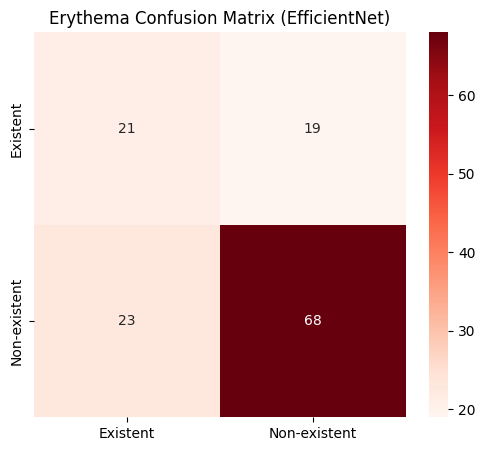

In [8]:
# ==========================================
# 1. SETUP
# ==========================================
TEST_CSV = "SurgWound_Cleaned/test_data.csv"
TEST_DIR = "SurgWound_Cleaned" 
MODEL_PATH = "erythema_efficientnet_final.h5"

print(f"⏳ Loading Pro-Model from {MODEL_PATH}...")

if not os.path.exists(MODEL_PATH):
    print(f"❌ ERROR: Could not find '{MODEL_PATH}'.")
    print("👉 Did you run the EfficientNet training script yet?")
else:
    model = tf.keras.models.load_model(MODEL_PATH)

    # ==========================================
    # 2. LOAD TEST DATA
    # ==========================================
    test_df = pd.read_csv(TEST_CSV)
    
    # Filter for Erythema task
    test_df = test_df[test_df['image_id'].str.contains("erythema", case=False)]
    
    # Ensure strings
    test_df['answer'] = test_df['answer'].astype(str)
    
    print(f"✅ Loaded {len(test_df)} Erythema test images.")

    # ==========================================
    # 3. CREATE GENERATOR
    # ==========================================
    # 🛑 IMPORTANT: No 'rescale' for EfficientNet! It handles 0-255 internally.
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator() 

    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=TEST_DIR,
        x_col="filename",
        y_col="answer",
        target_size=(224, 224),
        batch_size=32,
        class_mode="sparse",
        shuffle=False  # Keep order for evaluation
    )

    # ==========================================
    # 4. PREDICT
    # ==========================================
    print("⏳ Running predictions...")
    predictions = model.predict(test_gen, verbose=1)
    
    # Get the "Existent" probability (Class 0)
    # We use this for the Threshold check
    existent_probs = predictions[:, 0] 
    
    # Apply Threshold (0.5 is standard, but you can tune this later)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_gen.classes

    # Get Class Names
    class_labels = {v: k for k, v in test_gen.class_indices.items()}
    class_names = [class_labels[i] for i in range(len(class_labels))]
    
    print(f"Mapped Classes: {class_labels}")

    # ==========================================
    # 5. RESULTS
    # ==========================================
    print("\n" + "="*40)
    print("📊 EFFICIENTNET RESULTS (ERYTHEMA)")
    print("="*40)
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Erythema Confusion Matrix (EfficientNet)')
    plt.show()

In [4]:
# ==========================================
# 1. CONFIGURATION
# ==========================================
TRAIN_DIR = "SurgWound_Augmented"        
TRAIN_CSV = "SurgWound_Augmented/train_aug_data.csv"
VAL_DIR = "SurgWound_Cleaned"            
VAL_CSV = "SurgWound_Cleaned/validation_data.csv"

# Weights (Erythema)
CLASS_WEIGHTS = {0: 1.79, 1: 0.69}

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 25  # Increased epochs (Regularization makes learning slower but better)

# ==========================================
# 2. AGGRESSIVE AUGMENTATION
# ==========================================
train_datagen = ImageDataGenerator(
    rotation_range=45,           # Higher rotation
    width_shift_range=0.2,       # Higher shift
    height_shift_range=0.2,
    zoom_range=0.3,              # Higher zoom
    horizontal_flip=True,
    vertical_flip=True,          # Added vertical flip
    brightness_range=[0.7, 1.3], # More lighting variance
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator() # Raw pixels for validation

# ==========================================
# 3. DATA LOADERS
# ==========================================
train_df = pd.read_csv(TRAIN_CSV)
train_df['answer'] = train_df['answer'].astype(str)

val_df = pd.read_csv(VAL_CSV)
val_df = val_df[val_df['image_id'].str.contains("erythema", case=False)]
val_df['answer'] = val_df['answer'].astype(str)

train_gen = train_datagen.flow_from_dataframe(
    train_df, TRAIN_DIR, x_col="filename", y_col="answer",
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="sparse", shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df, VAL_DIR, x_col="filename", y_col="answer",
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="sparse", shuffle=False
)

# ==========================================
# 4. BUILD REGULARIZED MODEL
# ==========================================
def build_robust_model():
    inputs = Input(shape=(224, 224, 3))
    
    # Base: EfficientNetB0
    base_model = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=inputs)
    
    # Freeze bottom, Train top 30 layers
    base_model.trainable = True
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    
    # 🛡️ THE ANTI-OVERFITTING LAYER
    x = layers.Dense(128, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.001))(x) # L2 Penalty
    
    x = layers.Dropout(0.6)(x) # 60% Dropout (Very High)
    
    outputs = layers.Dense(2, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name="Erythema_EfficientNet_Robust")
    
    model.compile(optimizer=optimizers.Adam(1e-4), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

model = build_robust_model()

# ==========================================
# 5. TRAINING
# ==========================================
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.5, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

print("\n🛡️ Starting Robust Training...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=CLASS_WEIGHTS,
    callbacks=[lr_reduction, early_stop],
    verbose=1
)

model.save("erythema_efficientnet_robust.h5")
print("✅ Saved Model: erythema_efficientnet_robust.h5")

Found 2778 validated image filenames belonging to 2 classes.
Found 66 validated image filenames belonging to 2 classes.

🛡️ Starting Robust Training...
Epoch 1/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 78s 399ms/step - accuracy: 0.6120 - loss: 1.2839 - val_accuracy: 0.5606 - val_loss: 1.0093 - learning_rate: 1.0000e-04
Epoch 2/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 44s 251ms/step - accuracy: 0.6436 - loss: 1.0946 - val_accuracy: 0.5455 - val_loss: 1.0922 - learning_rate: 1.0000e-04
Epoch 3/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 43s 247ms/step - accuracy: 0.6955 - loss: 0.9352 - val_accuracy: 0.6061 - val_loss: 1.1639 - learning_rate: 1.0000e-04
Epoch 4/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 43s 249ms/step - accuracy: 0.7271 - loss: 0.8222 - val_accuracy: 0.6212 - val_loss: 1.1484 - learning_rate: 1.0000e-04
Epoch 5/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.7648 - loss: 0.7647
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
174/174 ━━━━━━━━━━━━━━━━━━━━ 43s 245ms/step - ac

✅ Saved Model: erythema_efficientnet_robust.h5


⏳ Loading Robust Model from erythema_efficientnet_robust.h5...


✅ Loaded 131 Erythema test images.
Found 131 validated image filenames belonging to 2 classes.
⏳ Running predictions...
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 669ms/step
Mapped Classes: {0: 'Existent', 1: 'Non-existent'}

📊 ROBUST EFFICIENTNET RESULTS
              precision    recall  f1-score   support

    Existent       0.44      0.55      0.49        40
Non-existent       0.78      0.69      0.73        91

    accuracy                           0.65       131
   macro avg       0.61      0.62      0.61       131
weighted avg       0.67      0.65      0.66       131



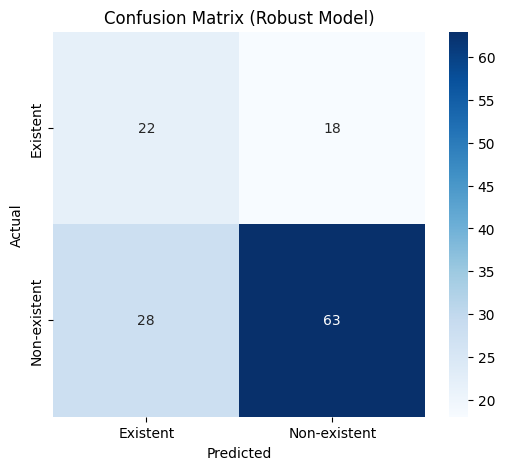

In [5]:
# ==========================================
# 1. CONFIGURATION
# ==========================================
TEST_CSV = "SurgWound_Cleaned/test_data.csv"
TEST_DIR = "SurgWound_Cleaned" 
MODEL_PATH = "erythema_efficientnet_robust.h5"  # <--- NEW MODEL NAME

print(f"⏳ Loading Robust Model from {MODEL_PATH}...")

if not os.path.exists(MODEL_PATH):
    print(f"❌ ERROR: Could not find '{MODEL_PATH}'.")
    print("👉 Make sure the training script finished and saved the file!")
else:
    model = tf.keras.models.load_model(MODEL_PATH)

    # ==========================================
    # 2. LOAD & FILTER TEST DATA
    # ==========================================
    test_df = pd.read_csv(TEST_CSV)
    
    # Filter for Erythema task
    test_df = test_df[test_df['image_id'].str.contains("erythema", case=False)]
    
    # Ensure strings
    test_df['answer'] = test_df['answer'].astype(str)
    
    print(f"✅ Loaded {len(test_df)} Erythema test images.")

    # ==========================================
    # 3. CREATE GENERATOR
    # ==========================================
    # 🛑 REMINDER: EfficientNet expects raw 0-255 pixels (No rescale)
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator() 

    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=TEST_DIR,
        x_col="filename",
        y_col="answer",
        target_size=(224, 224),
        batch_size=32,
        class_mode="sparse",
        shuffle=False  # Critical for matching predictions to labels
    )

    # ==========================================
    # 4. PREDICT
    # ==========================================
    print("⏳ Running predictions...")
    predictions = model.predict(test_gen, verbose=1)
    
    # Convert probabilities to Class IDs
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_gen.classes

    # Get Class Names
    class_labels = {v: k for k, v in test_gen.class_indices.items()}
    class_names = [class_labels[i] for i in range(len(class_labels))]
    
    print(f"Mapped Classes: {class_labels}")

    # ==========================================
    # 5. RESULTS
    # ==========================================
    print("\n" + "="*40)
    print("📊 ROBUST EFFICIENTNET RESULTS")
    print("="*40)
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Robust Model)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [9]:
# ==========================================
# 1. SETUP
# ==========================================
TEST_CSV = "SurgWound_Cleaned/test_data.csv"
TEST_DIR = "SurgWound_Cleaned" 
MODEL_PATH = "erythema_efficientnet_robust.h5" # Loading EfficientNet

print(f"⏳ Loading {MODEL_PATH}...")
if not os.path.exists(MODEL_PATH):
    print("❌ Error: Model not found!")
else:
    model = tf.keras.models.load_model(MODEL_PATH)

    # ==========================================
    # 2. GENERATE PREDICTIONS (NO RESCALE for EfficientNet)
    # ==========================================
    test_df = pd.read_csv(TEST_CSV)
    test_df = test_df[test_df['image_id'].str.contains("erythema", case=False)]
    test_df['answer'] = test_df['answer'].astype(str)

    # 🛑 DIFFERENCE: No rescale=1./255 here!
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
    
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test_df, directory=TEST_DIR, x_col="filename", y_col="answer",
        target_size=(224, 224), batch_size=32, class_mode="sparse", shuffle=False
    )

    print("⏳ Predicting probabilities...")
    predictions = model.predict(test_gen, verbose=1)
    
    # Get Probability of Class 0 (Existent / Infection)
    existent_probs = predictions[:, 0] 
    y_true = test_gen.classes

    # ==========================================
    # 3. THRESHOLD SEARCH
    # ==========================================
    print("\n" + "="*60)
    print(f"EFFICIENTNET THRESHOLD ANALYSIS")
    print("-" * 60)
    print(f"{'Threshold':<10} | {'Recall (Catch Rate)':<20} | {'Precision':<10} | {'Accuracy':<10}")
    print("="*60)

    best_thresh = 0.5
    
    for thresh in np.arange(0.1, 0.95, 0.05):
        # If prob > thresh, predict 0 (Existent/Infection)
        y_pred_thresh = [0 if p > thresh else 1 for p in existent_probs]
        
        # Metrics for Class 0
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_thresh, labels=[0], zero_division=0)
        
        # Overall Accuracy
        acc = np.mean(np.array(y_pred_thresh) == y_true)
        
        print(f"{thresh:.2f}       | {recall[0]:.2%}             | {precision[0]:.2%}     | {acc:.2%}")

    print("="*60)

⏳ Loading erythema_efficientnet_robust.h5...


Found 131 validated image filenames belonging to 2 classes.
⏳ Predicting probabilities...
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 622ms/step

EFFICIENTNET THRESHOLD ANALYSIS
------------------------------------------------------------
Threshold  | Recall (Catch Rate)  | Precision  | Accuracy  
0.10       | 92.50%             | 30.58%     | 33.59%
0.15       | 85.00%             | 30.09%     | 35.11%
0.20       | 82.50%             | 33.00%     | 43.51%
0.25       | 80.00%             | 34.78%     | 48.09%
0.30       | 75.00%             | 37.04%     | 53.44%
0.35       | 72.50%             | 38.16%     | 55.73%
0.40       | 62.50%             | 39.06%     | 58.78%
0.45       | 60.00%             | 41.38%     | 61.83%
0.50       | 55.00%             | 44.00%     | 64.89%
0.55       | 42.50%             | 43.59%     | 65.65%
0.60       | 32.50%             | 44.83%     | 67.18%
0.65       | 27.50%             | 45.83%     | 67.94%
0.70       | 20.00%             | 44.44%     | 67.94%
0.75       | 17